<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

> **把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非學術用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

!gdown --id 1gMpt0CdlPjr1cR3HwDqumeKaucrSYhhe --output "./Eileen_Legendary.txt"

# !wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gMpt0CdlPjr1cR3HwDqumeKaucrSYhhe
To: /content/Eileen_Legendary.txt
100% 818k/818k [00:00<00:00, 73.3MB/s]


## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
# 作業之一就是試試看其他本小說

book = ""
with open("./books/曹雪芹《紅樓夢》.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"曹雪芹紅樓夢共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

曹雪芹紅樓夢共有 874680 字詞
包含了 4548 個獨一無二的字 (含標點符號)


《二○一六年十月七日版》
《好讀書櫃》經典版
第一回 甄士隱夢幻識通靈 賈雨村風塵懷閨秀
此開卷第一回也。作者自云：因曾歷過一番夢幻之後，故將真事隱去，而借「通靈」之說，撰此《石頭記》一書也。故曰「甄士隱」云云。但書中所記何事何人？自又云：「今風塵碌碌，一事無成，忽念及當日所有之女子，一一細考較去，覺其行止見識，皆出於我之上。何我堂堂鬚眉，誠不若彼裙釵哉？實愧則有餘，悔又無益之大無可如何之日也！當此，則自欲將已往所賴天恩祖德，錦衣紈袴……之時，飫甘饜肥之日，背父兄教育之恩，負師友規談之德，以至今日一技無成，半生潦倒之罪，編述一集，以告天下人：我之罪固不免，然閨閣中本自歷歷有人，萬不可因我之不肖，自護己短，一併使其泯滅也。雖今日之茅椽蓬牖，瓦灶繩床，其晨夕風露，階柳庭花，亦未有妨我之襟懷筆墨者。雖我未學，下筆無文，又何妨用假語村言，敷演出一段故事來，亦可使閨閣昭傳，復可悅世之目，破人愁悶，不亦宜乎？」故曰「賈雨村」云云。
此回中凡用「夢」用「幻」等字，是提醒閱者眼目，亦是此書立意本旨。
列位看官：你道此書從何而來？說起根由雖近荒唐，細按則深有趣味。待在下將此來歷注明，方使閱者了然不惑。


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 2590


In [ ]:
print(f"原本曹雪芹紅樓夢共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本曹雪芹紅樓夢共有 874680 字詞
去除不常出現的文字後
剩餘868770個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '一', '六', '年', '十', '月', '七', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經', '典', '\n', '第', '一', '回', ' ', '甄', '士', '隱', '夢', '幻', '識', '通', '靈', ' ', '賈', '雨', '村', '風', '塵', '懷']
----------------------------------------
轉成index : 
{2304, 2562, 2053, 2441, 2057, 2316, 2188, 1555, 2584, 1825, 2552, 1834, 1842, 691, 1978, 2371, 1483, 2123, 1364, 2136, 2137, 2010, 859, 1883, 2399, 2529, 2021, 2535, 2536, 2544, 1904, 1905, 2424, 1659}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[2544 2136 2529 2584 1904 2441 2424 2399 1883 2536 2137 2544 2136 2552
 1834 2371  859 2137 2316 1364 2544], shape=(21,), dtype=int32)
['\n', '《', '二', '一', '六', '年', '十', '月', '七', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經', '典', '\n']
(21,)
tf.Tensor(
[2057 2584 2535  691 1842 2053 1905 1978 1483 1659 2010 2021  691 2562
 2188 2123 2304 1555 1825 1294 1097], shape=(21,), dtype=int32)
['第', '一', '回', ' ', '甄', '士', '隱', '夢', '幻', '識', '通', '靈', ' ', '賈', '雨', '村', '風', '塵', '懷', '閨', '秀']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['\n', '《', '二', '一', '六', '年', '十', '月', '七', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經', '典']
Target: ['《', '二', '一', '六', '年', '十', '月', '七', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經', '典', '\n']
--------------------------------------------------
Input : [2544 2136 2529 2584 1904 2441 2424 2399 1883 2536 2137 2544 2136 2552
 1834 2371  859 2137 2316 1364]
Target: [2136 2529 2584 1904 2441 2424 2399 1883 2536 2137 2544 2136 2552 1834
 2371  859 2137 2316 1364 2544]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 20), dtype=tf.int32, name=None), TensorSpec(shape=(64, 20), dtype=tf.int32, name=None))>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()
model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))
model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))
model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         1326080   
                                                                 
 lstm (LSTM)                 (None, None, 4096)        75513856  
                                                                 
 lstm_1 (LSTM)               (None, None, 2048)        50339840  
                                                                 
 dense (Dense)               (None, None, 2590)        5306910   
                                                                 
Total params: 132,486,686
Trainable params: 132,486,686
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 2590)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
留飯，不可久待，遂從夾道中自便出門去了。
----------------------------------------
輸入尚未訓練的model後獲得：

仁聘豪豪豪豪豪豪豪豪豪周周周周虔辯辯辯辯


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
646/646 [==============================] - 468s 718ms/step - loss: 5.1719
Epoch 2/20
646/646 [==============================] - 462s 714ms/step - loss: 4.3325
Epoch 3/20
646/646 [==============================] - 461s 712ms/step - loss: 4.0287
Epoch 4/20
646/646 [==============================] - 460s 711ms/step - loss: 3.8054
Epoch 5/20
646/646 [==============================] - 459s 710ms/step - loss: 3.5941
Epoch 6/20
646/646 [==============================] - 459s 709ms/step - loss: 3.3648
Epoch 7/20
646/646 [==============================] - 458s 708ms/step - loss: 3.0935
Epoch 8/20
646/646 [==============================] - 458s 708ms/step - loss: 2.7703
Epoch 9/20
646/646 [==============================] - 458s 708ms/step - loss: 2.3883
Epoch 10/20
646/646 [==============================] - 458s 709ms/step - loss: 1.9600
Epoch 11/20
646/646 [==============================] - 458s 708ms/step - loss: 1.5162
Epoch 12/20
646/646 [==============================] - 458s 709

## 6. 衡量模型

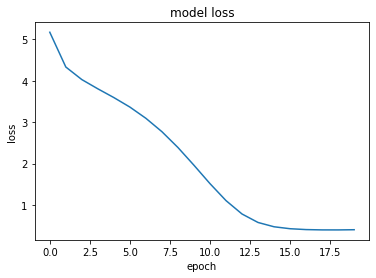

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
留飯，不可久待，遂從夾道中自便出門去了。
----------------------------------------
輸入進訓練後的model後獲得：

神，不可久待，遂從夾道中自便出門去了。士


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]



In [ ]:
init_seq = "劉姥姥"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

劉姥姥道：「說著瞧罷。」於是兩人各自走開。
這裏尤二姐亦不答言，只有賈璉、賈蘭等人來了，便和賈蘭道：「你們都是仁莊人，只怕他們爺兒兩個權進園，你就是賊一輩子的修活，活了也可以使得。若是別了，咱們先前放聲大兒。你可以不用說那些話。你是誰，就叫賴大拿了去罷。」襲人道：「你要不去，就在這裏住下。」那人道：「我們的籤最是靈的，所以叫你們也多謝。你要攆她，你只管放心，有我呢。」一面說著，一面又取不來。一時擺上飯來，寶玉也不吃飯，便坐下了，仍是悶悶的歪在床上，見了雪雁，便跑進屋來。只見寶釵睡了，因說道：「妹妹的病也不用別的了。」寶玉道：「你也不知道，我是不中用的。就是我在這裏看著的。不過是借一兩件事來，就不該早前留神，說有事回太太。今日你問，你自己去了。」眾人都道：「也要才散的，只管送去。」探春道：「怎麼也不曾告訴他們。」賈政道：「你們不知道的，只有一個蒲團，一個瓢兒還好，我就沒看見你。」
寶玉聽了，喜得眉開眼笑，說道：「我卻沒有聽見，薛大爺在這裏照應，還有一個死呢。」寶玉道：「也不是做詩。」襲人道：「只是不知道，大約別的，咱們說不中用，就請太太的安。」鳳姐道：「我也正想著打發人來瞧，少不得今兒說我的父

In [ ]:
# 不要執行這一個block
import time
while True:
  time.sleep(5)
  pass

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。

In [ ]:
import requests
from lxml import etree
import re 
import urllib
from tqdm import tqdm
import os

if(os.path.isdir("./books") == False):
  os.mkdir("./books")

In [ ]:
def get_book_information(url):
  url_chinese = urllib.parse.unquote(url)
  url_re = re.compile(r'com/(.*)\.php')
  url_re2 = re.compile(r'.*\.php')
  url_re3 = re.compile(r'\.(html|xhtml)')
  save_path = "./books/"+url_re.search(url_chinese).group(1).strip()+".txt"
  url_book_domain = url_re2.match(url).group(0)
  html_format = url_re3.search(url).group(0)
  print("儲存位置: "+save_path)
  return save_path,url_book_domain,html_format

In [ ]:
def get_pages_of_book(url):
  response = requests.get(url+"#book_toc")
  html = etree.HTML(response.content)
  content_number = len(html.xpath('.//div[@data-role="content"]//ul/li'))
  return content_number

In [ ]:
def download_one_book(url):
  save_path,url_book_domain,html_format = get_book_information(url)
  content_number = get_pages_of_book(url)
  page_start = 2 if(html_format == ".html") else 1
  page_end = page_start+content_number
  file = open(save_path,"w",encoding="utf8")
  for page in tqdm(range(page_start,page_end)):
      if(html_format == ".html"):
          url_ = url_book_domain+"/"+(str(page) if page>9 else "0"+str(page))+html_format
      else:
          url_ = url_book_domain+"/"+str(page)+html_format
      response = requests.get(url_)
      html = etree.HTML(response.content.decode("utf-8","replace"))
      if(html_format == ".html"):
          content = html.xpath('.//div[@data-role="content"]/p/text()')
      else:
          content = html.xpath('.//div[@data-role="content"]/div/text()')
      assey = [a.strip().replace("\u3000"," ") for a in content]
      file.write("\n".join(assey)+"\n")
  file.flush()
  file.close()

In [ ]:


url = "https://www.bookscool.com/%E6%9B%B9%E9%9B%AA%E8%8A%B9%E3%80%8A%E7%B4%85%E6%A8%93%E5%A4%A2%E3%80%8B.php/1.xhtml"
download_one_book(url)

儲存位置: ./books/曹雪芹《紅樓夢》.txt


100%|██████████| 120/120 [01:47<00:00,  1.12it/s]
